# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
print(y_train)
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

[ 0  0  0 ..., 42 42 42]
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np

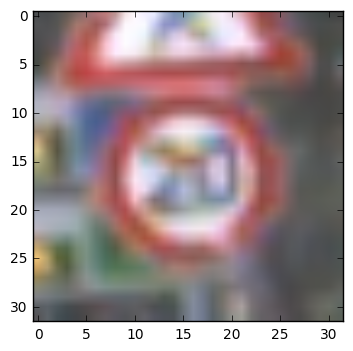

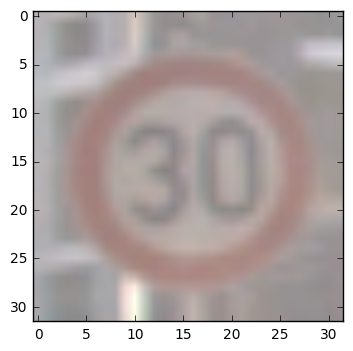

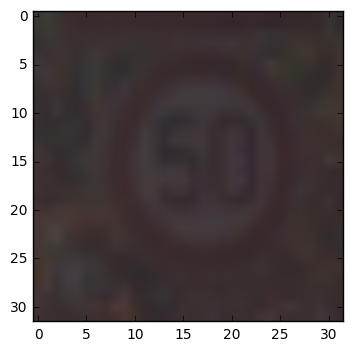

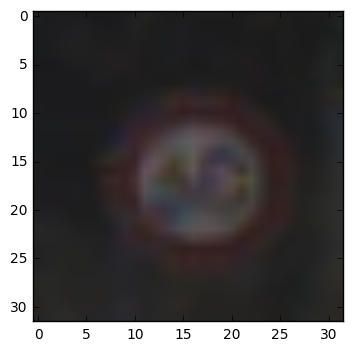

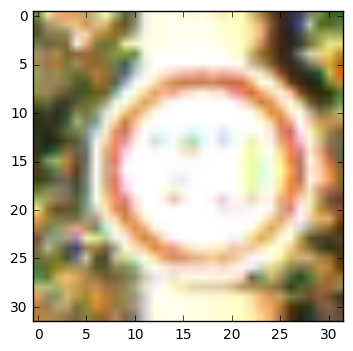

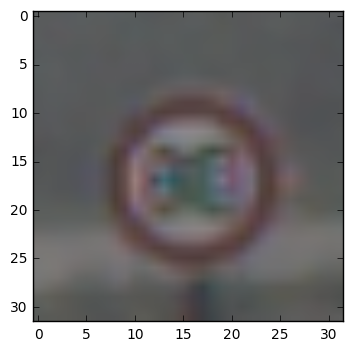

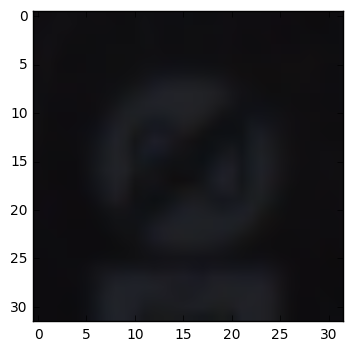

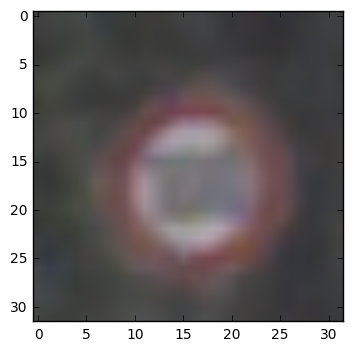

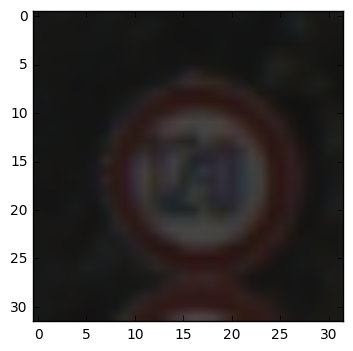

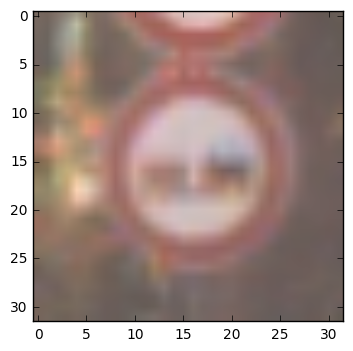

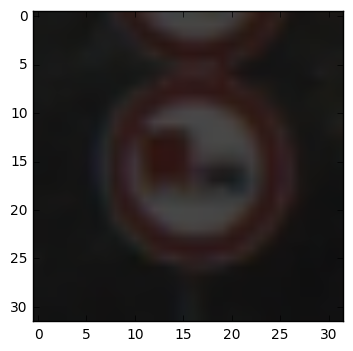

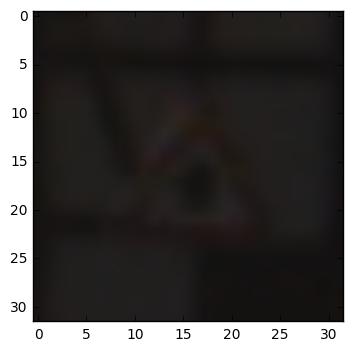

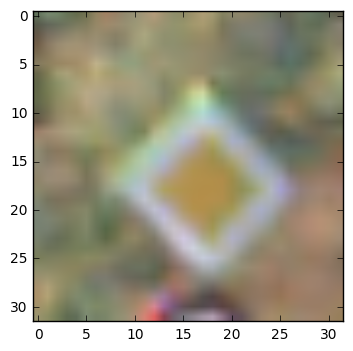

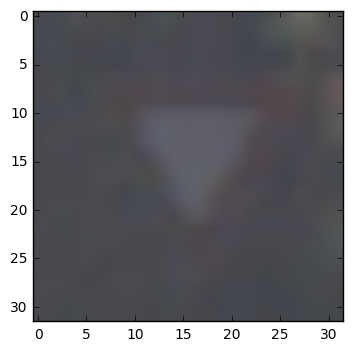

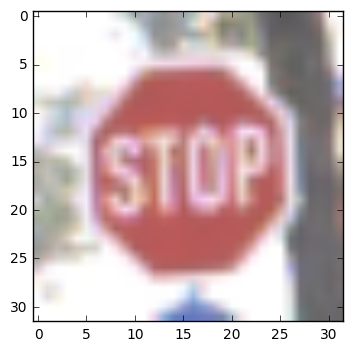

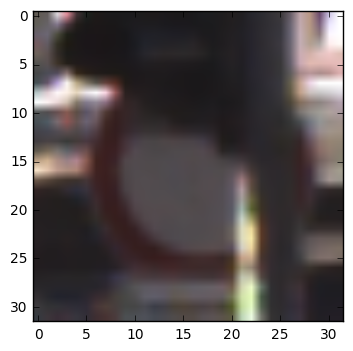

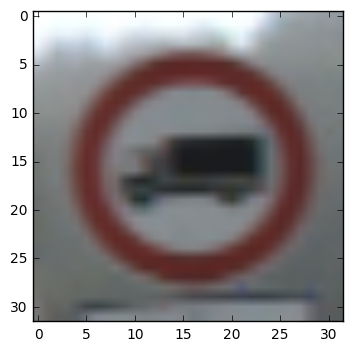

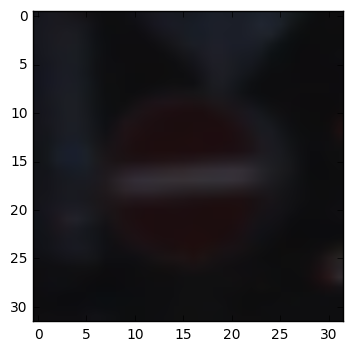

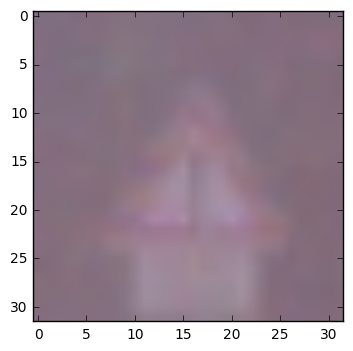

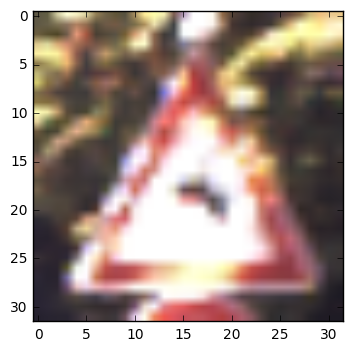

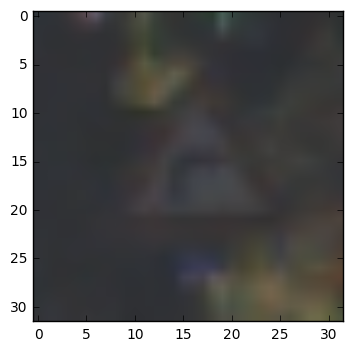

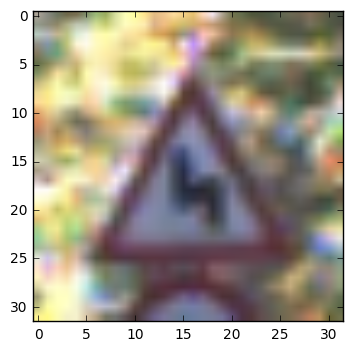

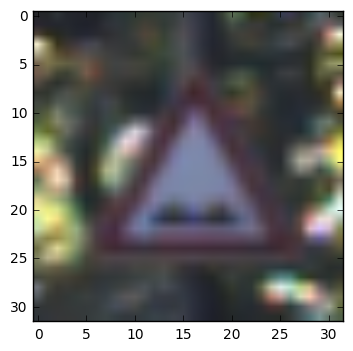

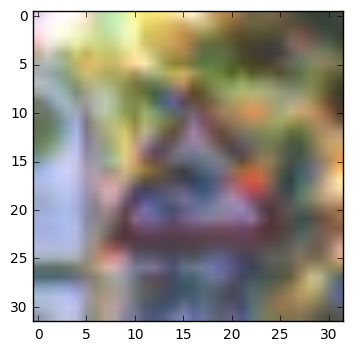

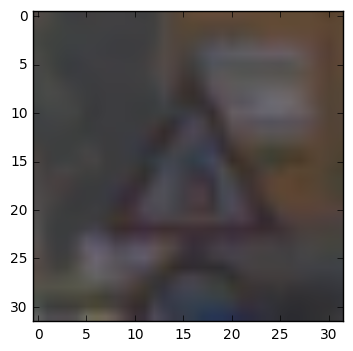

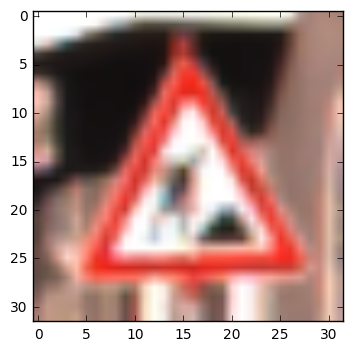

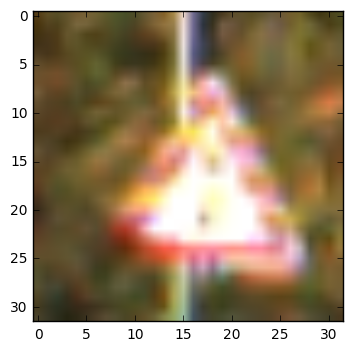

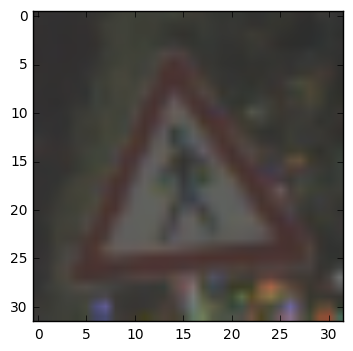

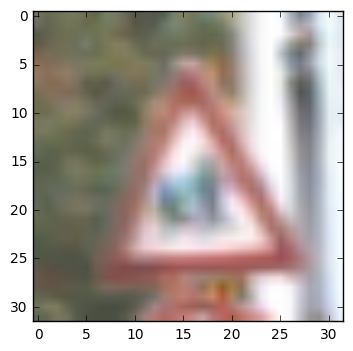

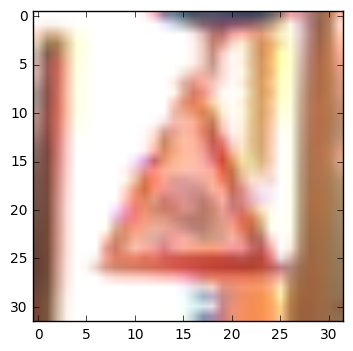

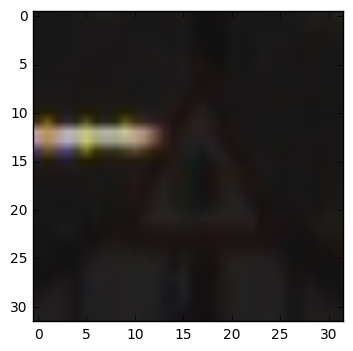

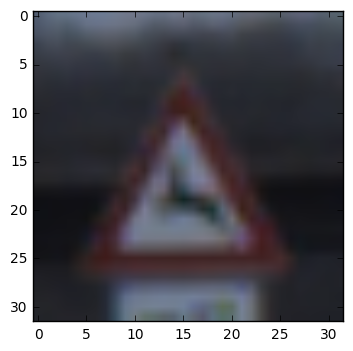

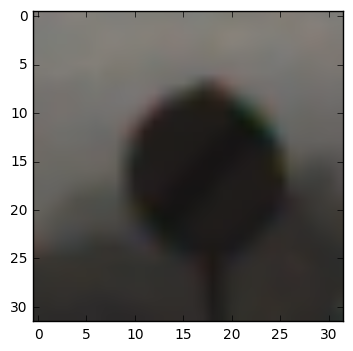

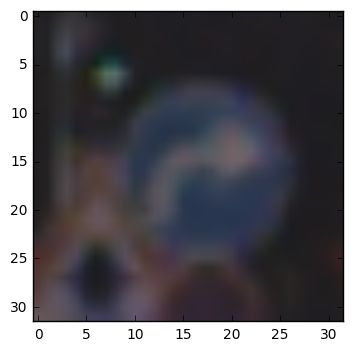

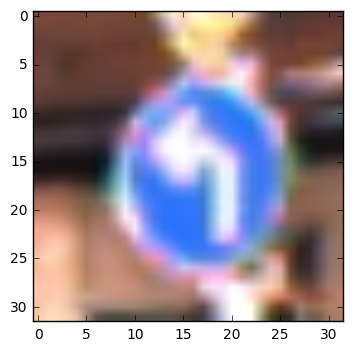

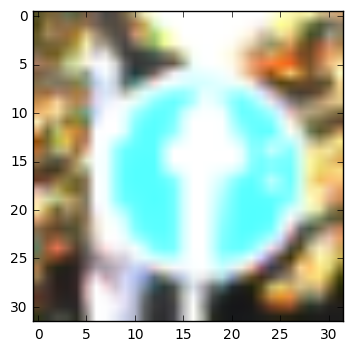

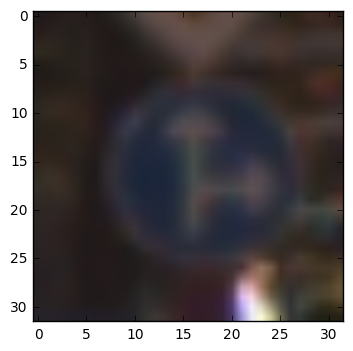

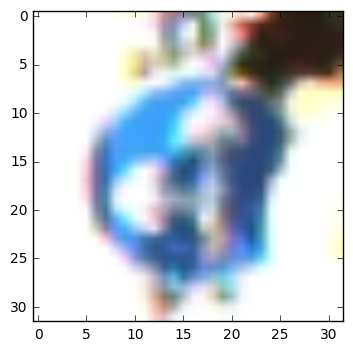

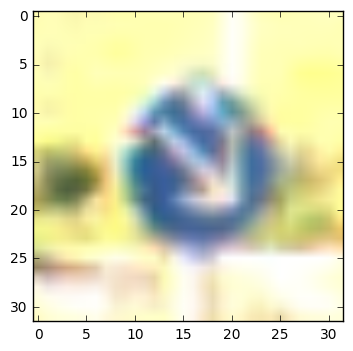

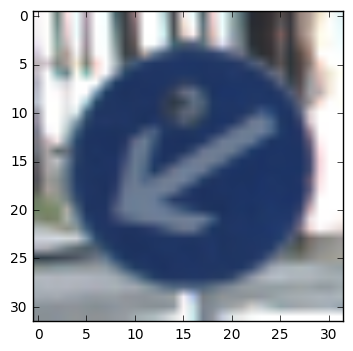

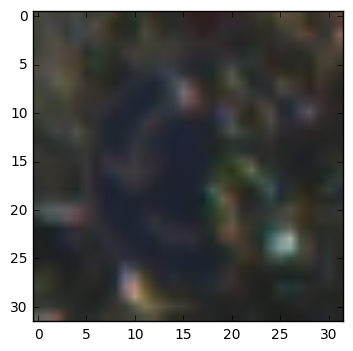

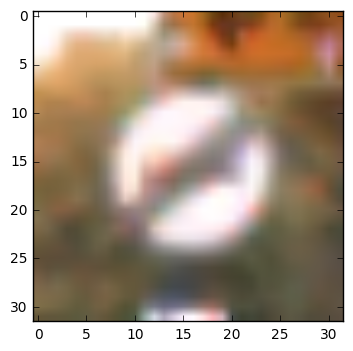

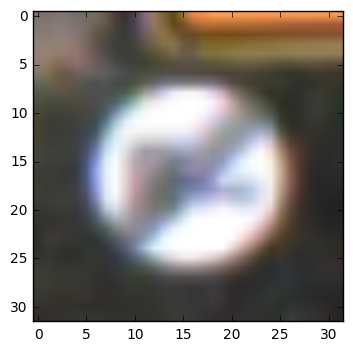

In [5]:
# Show one of each sign class
img_is = []
label_num = 0
for i, label in enumerate(y_train):
    if label == label_num:
        img_is.append(i)
        label_num += 1

signs = X_train[img_is]

for img in signs:
    plt.figure(i + 1)
    plt.imshow(img)
    plt.show()
    
# Clear that the brightness needs to be normalized

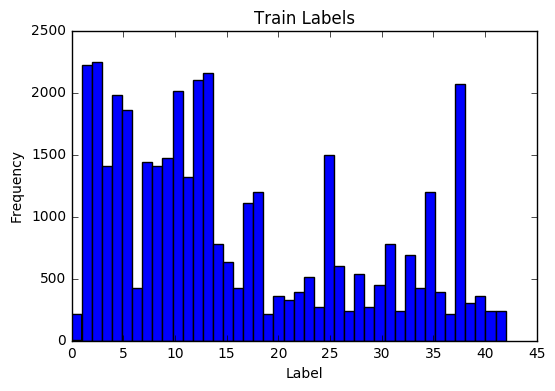

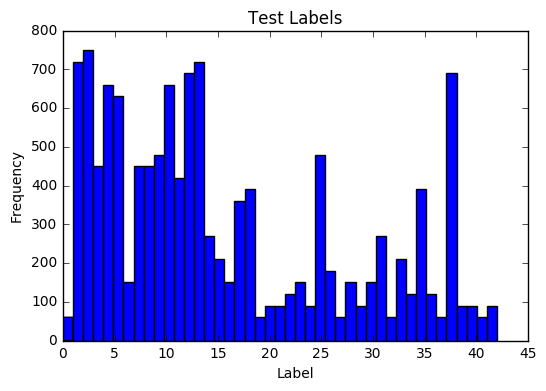

In [6]:
# Display histograms of class frequencies
plt.hist(y_train, bins=n_classes)
plt.title("Train Labels")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

plt.hist(y_test, bins=n_classes)
plt.title("Test Labels")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

# roughly same distribution of train and test data
# some of the less-frequent classes should be augmented

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
# TEST print out images matched with labels
label_names = np.array([
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vechiles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vechiles',
    'Vechiles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vechiles over 3.5 metric tons'])

def show_imgs_labels(imgs, labels, num=5):
    indeces = np.random.choice(len(imgs), num, replace=False)
    for i in indeces:
        label = label_names[labels[i]]
        
        img = imgs[i]
        if img.shape[2] == 1:
            img = img[:, :, 0]
        
        print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.show()
    

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from skimage import exposure

def rgb2gray(imgs):
    # convert to grayscale
    return np.mean(imgs, axis=3, keepdims=True)

def normalize(imgs):
    # normalize to [-1, 1] range
    return imgs / (255 / 2.) - 1

def denormalize(imgs):
    # denormalize to [0, 255] range
    return ((imgs + 1) * (255 / 2.)).astype(np.uint8)

def equalize(imgs):
    # equalize contrast
    new_imgs = np.empty(imgs.shape, dtype=float)
    for i, img in enumerate(imgs):
        equalized_img = exposure.equalize_adapthist(img) * 2 - 1
        new_imgs[i] = equalized_img

    return new_imgs
    
def preprocess(imgs):
    new_imgs = equalize(imgs)
    new_imgs = rgb2gray(new_imgs)
    
    return new_imgs

In [9]:
# test to make sure normalization is working

# print(np.amax(X_train))
# print(np.amin(X_train))

# normd = normalize(X_train)
# print(np.amax(normd))
# print(np.amin(normd))

# denormd = denormalize(normd)
# print(np.amax(denormd))
# print(np.amin(denormd))

# print(np.equal(X_train[0], denormd[0]).all())

In [10]:
# test to make sure equalization is working

# imgs_to_eq = X_train[9999:10000]
# imgs_eqd = preprocess(imgs_to_eq)

# plt.figure(1)
# plt.imshow(imgs_to_eq[0])
# plt.show()

# plt.figure(2)
# plt.imshow(imgs_eqd[0, :, :, 0])
# plt.show()

In [11]:
# preprocess the images
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

# shuffle the training/validation images with labels
inputs_train_valid, labels_train_valid = map(np.array, zip(*np.random.permutation(list(zip(X_train_processed, y_train)))))

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


Stop


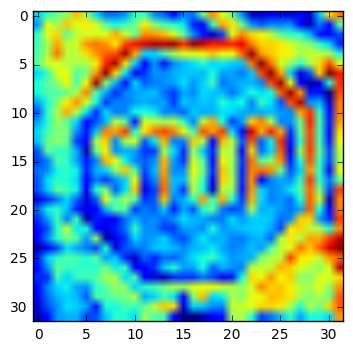

Turn right ahead


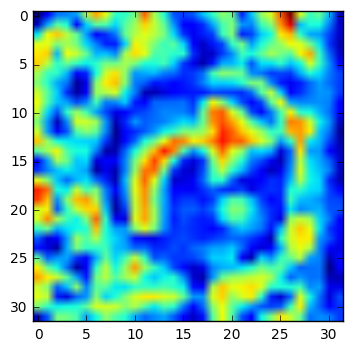

Speed limit (120km/h)


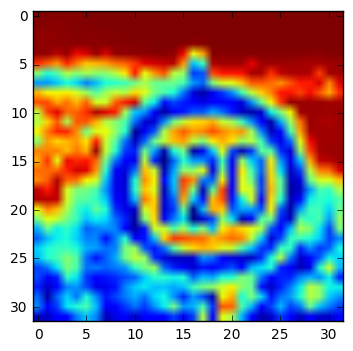

Speed limit (50km/h)


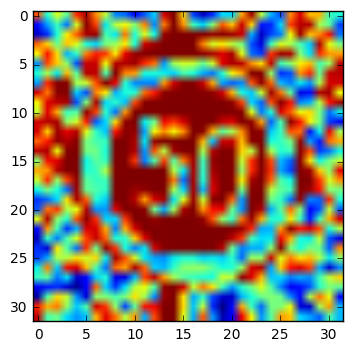

Road work


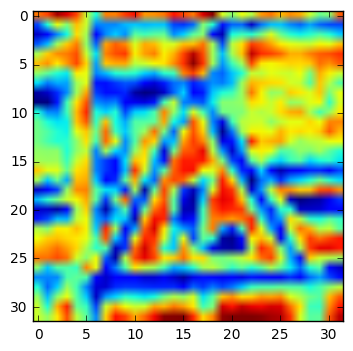

In [12]:
# visualize new images
show_imgs_labels(inputs_train_valid, labels_train_valid)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** I normalized the images by scaling all of their values betweeon -1 and 1 and equalizing the contrast using adaptive hist. I also converted from RGB color to luminance. All of these should help with the brightness/contrast differences in the original images.

Road work


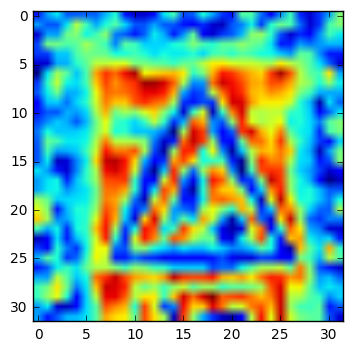

Speed limit (70km/h)


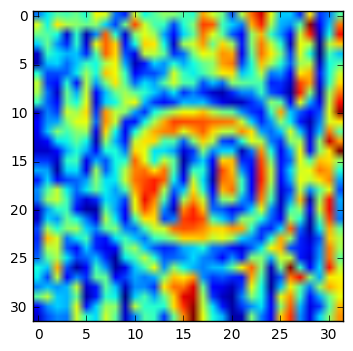

Keep right


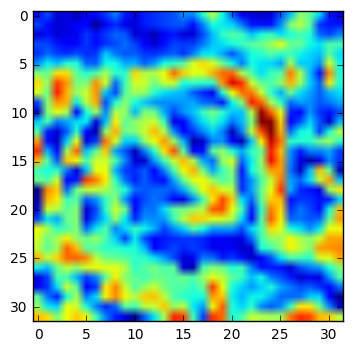

Ahead only


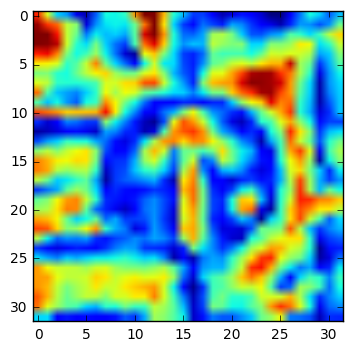

Speed limit (30km/h)


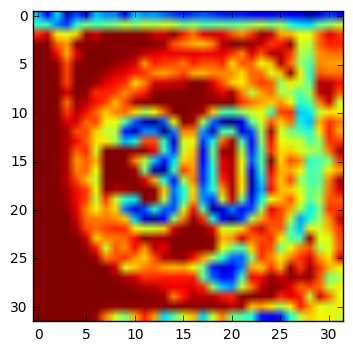

In [13]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

split_i = int(len(inputs_train_valid) * 0.1) # 10% of the train images

inputs_validation = inputs_train_valid[:split_i]
labels_validation = labels_train_valid[:split_i]

inputs_train = inputs_train_valid[split_i:]
labels_train = labels_train_valid[split_i:]

# for naming consistency
inputs_test = X_test_processed
labels_test = y_test 

show_imgs_labels(inputs_train, labels_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** For testing I used the given test split. To create a validation set, I shuffled the train data and took the first 10%, then used the remaining 90% as train data.

In [14]:
##
# Helpers
##

def w(shape, seed=None):
    """
    @return A weight layer with the given shape. Initialized with a xavier distribution.
    """
#     if len(shape) == 2: # fully-connected
#         num_in = shape[0]
#         num_out = shape[1]
#     elif len(shape) == 4: # convolution
#         num_in = shape[0] * shape[1] * shape[2]
#         num_out = shape[0] * shape[1] * shape[3]
#     else:
#         num_in = 1
#         num_out = 1

#     low = -4 * np.sqrt(6.0 / (num_in + num_out))  # {sigmoid:4, tanh:1}
#     high = 4 * np.sqrt(6.0 / (num_in + num_out))

#     return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), dtype=tf.float32)


def b(shape, const=0.1):
    """
    @return A bias layer with the given shape.
    """
    return tf.Variable(tf.constant(const, shape=shape))

In [41]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

class Model:
    def __init__(self, sess, lrate):
        self.sess = sess
        self.lrate = lrate
        
        self.define_graph()
        
    def define_graph(self):
        with tf.name_scope('Data'):
            self.inputs = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], 1])
            self.labels = tf.placeholder(tf.uint8)
            self.labels_onehot = tf.one_hot(self.labels, n_classes)
        
        with tf.name_scope('Variables'):
            self.ws_conv = []
            self.bs_conv = []
            self.ws_fc   = []
            self.bs_fc   = []

            conv_fms = [1, 32, 64, 128]
            filter_sizes = [5, 5, 3]

            fc_sizes = [2048, 512, n_classes]
            
            with tf.name_scope('Conv'):
                for layer in range(len(filter_sizes)):
                    with tf.name_scope(str(layer)):
                        self.ws_conv.append(w([filter_sizes[layer],
                                               filter_sizes[layer],
                                               conv_fms[layer],
                                               conv_fms[layer + 1]]))
                        self.bs_conv.append(b([conv_fms[layer + 1]]))
                        
            with tf.name_scope('FC'):
                for layer in range(len(fc_sizes) - 1):
                    with tf.name_scope(str(layer)):
                        self.ws_fc.append(w([fc_sizes[layer], fc_sizes[layer + 1]]))
                        self.bs_fc.append(b([fc_sizes[layer + 1]]))
                        
        with tf.name_scope('Training'):
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(self.get_logits(self.inputs), self.labels_onehot))
            
            self.global_step = tf.Variable(0, trainable=False)
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lrate)
            self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.preds = self.get_preds(self.inputs)
            
            with tf.variable_scope('Accuracy'):
                self.accuracy, self.update_accuracy_op = tf.contrib.metrics.streaming_accuracy(
                        tf.argmax(self.preds, 1), self.labels)
            
    def get_logits(self, inputs):
        with tf.name_scope('Calculation'):
            logits = inputs
            
            with tf.name_scope('Conv'):
                for layer, (kernel, bias) in enumerate(zip(self.ws_conv, self.bs_conv)):
                    with tf.name_scope(str(layer)):
                        logits = tf.nn.conv2d(logits, kernel, [1, 1, 1, 1], 'SAME') + bias
                        logits = tf.nn.max_pool(logits, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
                        logits = tf.nn.relu(logits)
                        
            # flatten logits
            shape = tf.shape(logits)
            logits = tf.reshape(logits, [shape[0], shape[1] * shape[2] * shape[3]])
            
            with tf.name_scope('FC'):
                for layer, (weight, bias) in enumerate(zip(self.ws_fc, self.bs_fc)):
                    with tf.name_scope(str(layer)):
                        logits = tf.matmul(logits, weight) + bias
                        
                        # Activate with ReLU if not the last layer
                        if layer < len(self.ws_fc) - 1:
                            logits = tf.nn.relu(logits)
        
        return logits
    
    def get_preds(self, inputs):
        return tf.nn.softmax(self.get_logits(inputs))
    
    def train(self, inputs, labels):
        feed_dict = {self.inputs: inputs, self.labels: labels}
        loss, global_step, _ = self.sess.run(
            [self.loss, self.global_step, self.train_op], feed_dict=feed_dict)
        
        if global_step % 10 == 0:
            print('Step {} | Loss: {}'.format(global_step, loss))
            
        if global_step % 1000 == 0:
            self.test(inputs_validation, labels_validation)
            
        return global_step
    
    def test(self, inputs, labels):
        print('-' * 30)
        batch_gen = gen_epoch(inputs, labels, BATCH_SIZE)
        
        # reset accuracy streaming for each test run
        with tf.variable_scope('Accuracy'):
                self.accuracy, self.update_accuracy_op = tf.contrib.metrics.streaming_accuracy(
                        tf.argmax(self.preds, 1), self.labels)
        sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope='Accuracy')))
        
        total_loss = 0
        for step, (inputs, labels) in enumerate(batch_gen):
            feed_dict = {self.inputs: inputs, self.labels: labels}
            loss, preds, _ = self.sess.run([self.loss, self.preds, self.update_accuracy_op], feed_dict=feed_dict)
            
            total_loss += loss
            
            if step % 10 == 0:
                print('TEST | Step {} | Loss: {}'.format(step, loss))
            
        avg_loss = total_loss / float(step)
        accuracy = self.sess.run([self.accuracy])
        print('FINAL | LOSS: {} | ACCURACY: {}'.format(avg_loss, accuracy))
        print('-' * 30)
        
        return preds, avg_loss, accuracy
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I chose to use a CNN with 3 convolutional layers with 32, 64 and 128 feature maps, respectively, each followed by a 2x2 max pool. The network finishes with 3 fully connected layers of size 2048, 512 and n_classes.

In [42]:
##
# Helpers
##

def gen_epoch(inputs, labels, batch_size):
    for i in range(0, len(inputs), batch_size):
        batch_inputs = inputs[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        yield batch_inputs, batch_labels

In [43]:
##
# Hyperparameters
##

BATCH_SIZE = 32
NUM_EPOCHS = 10
LRATE = 0.001

In [44]:
##
# Initialization
##

sess = tf.Session()
model = Model(sess, LRATE)
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

[None, None]

In [46]:
### Train your model here.
### Feel free to use as many code cells as needed.

# train
for epoch in range(NUM_EPOCHS):
    batch_gen = gen_epoch(inputs_train, labels_train, BATCH_SIZE)
    for (inputs, labels) in batch_gen:
        step = model.train(inputs, labels)

Step 10 | Loss: 8.980218887329102
Step 20 | Loss: 4.1543354988098145
Step 30 | Loss: 3.678874969482422
Step 40 | Loss: 3.1950933933258057
Step 50 | Loss: 3.3250675201416016
Step 60 | Loss: 2.5627965927124023
Step 70 | Loss: 2.817206382751465
Step 80 | Loss: 2.5241236686706543
Step 90 | Loss: 2.272040605545044
Step 100 | Loss: 2.449357748031616
Step 110 | Loss: 2.2626209259033203
Step 120 | Loss: 1.9562703371047974
Step 130 | Loss: 1.693760633468628
Step 140 | Loss: 1.1873353719711304
Step 150 | Loss: 1.6328004598617554
Step 160 | Loss: 1.4981226921081543
Step 170 | Loss: 1.008286476135254
Step 180 | Loss: 1.1312708854675293
Step 190 | Loss: 1.0438060760498047
Step 200 | Loss: 0.7155331969261169
Step 210 | Loss: 0.8926148414611816
Step 220 | Loss: 0.9246691465377808
Step 230 | Loss: 0.7881110906600952
Step 240 | Loss: 0.7407172918319702
Step 250 | Loss: 0.8021509647369385
Step 260 | Loss: 0.8166457414627075
Step 270 | Loss: 0.7782595157623291
Step 280 | Loss: 0.9258050918579102
Step 290

In [47]:
model.test(inputs_test, labels_test)

------------------------------
TEST | Step 0 | Loss: 0.06773406267166138
TEST | Step 10 | Loss: 0.5820043087005615
TEST | Step 20 | Loss: 0.17098188400268555
TEST | Step 30 | Loss: 0.33150342106819153
TEST | Step 40 | Loss: 0.086811862885952
TEST | Step 50 | Loss: 0.23378056287765503
TEST | Step 60 | Loss: 0.026070473715662956
TEST | Step 70 | Loss: 7.57596135372296e-05
TEST | Step 80 | Loss: 0.6927139759063721
TEST | Step 90 | Loss: 0.6052408814430237
TEST | Step 100 | Loss: 0.9855444431304932
TEST | Step 110 | Loss: 0.023668959736824036
TEST | Step 120 | Loss: 0.13859210908412933
TEST | Step 130 | Loss: 0.6753004193305969
TEST | Step 140 | Loss: 0.02860642969608307
TEST | Step 150 | Loss: 0.4037588834762573
TEST | Step 160 | Loss: 0.6054102182388306
TEST | Step 170 | Loss: 0.4438280761241913
TEST | Step 180 | Loss: 0.09824968129396439
TEST | Step 190 | Loss: 0.6408196687698364
TEST | Step 200 | Loss: 0.47289717197418213
TEST | Step 210 | Loss: 0.6690344214439392
TEST | Step 220 | Los

(array([[  1.93670299e-18,   7.77988513e-14,   1.12829561e-17,
           4.47101510e-17,   3.81586050e-21,   1.19153849e-20,
           5.61698993e-16,   6.12312572e-24,   8.67390379e-19,
           3.53692363e-14,   9.85600382e-19,   1.82767063e-02,
           3.54522683e-07,   1.17520485e-15,   7.56046802e-18,
           1.42282603e-18,   3.68601168e-19,   6.77190170e-14,
           2.87367324e-10,   1.24583006e-18,   3.43154705e-09,
           1.02741019e-11,   1.29873582e-15,   3.40483619e-09,
           1.32904331e-14,   2.77987112e-11,   9.81721938e-01,
           8.51208654e-07,   3.27282926e-14,   8.02395952e-16,
           1.26584240e-07,   3.95006784e-18,   1.89300547e-14,
           2.21873504e-14,   1.17802367e-15,   1.61793682e-16,
           2.41325159e-14,   1.57287412e-11,   6.17542073e-10,
           5.91997018e-17,   1.06121119e-11,   3.10086971e-14,
           2.34268388e-13],
        [  2.54527844e-13,   5.49858385e-07,   7.39098605e-09,
           4.88562873e-05, 

**Final accuracy:**

Validation: 98.571% <br/>
Test: 92.708%

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I trained my model with an AdamOptimizer for 10 epochs on a batch size of 32. I originally started with a learning rate of 0.1, but bumped it down to 0.01, then 0.001 when the higher learning rates started plateuing and bouncing around at non-optimal loss values.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** I knew that because this is an image classifiaction problem, a convolutional network would be the way to go in order to take advantage of the spatial information in the images. My model initially wouldn't train well though. I found this was because the images in the data had a wide range of brightness (some were overexposed, and some were so dim they were hard to see). I fixed this by using histogram equalization to equalize the contrast. After doing this, I saw much better results. Given more time, I would have liked to have experimented with augmenting data for some of the classes that weren't as well represented in the training set.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [48]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from scipy.misc import imread, imresize
from os import listdir
from glob import glob

img_paths = glob('traffic-signs-data/test_images/*.png')

# load, resize and convert from rgba to rgb
test_imgs = np.array([imresize(imread(path)[:, :, :3], [image_shape[0], image_shape[1]]) for path in img_paths])

# preprocess
test_imgs = preprocess(test_imgs)

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


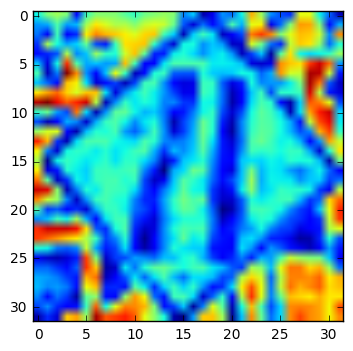

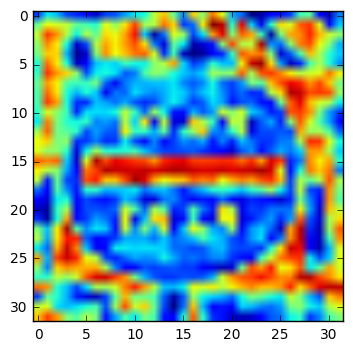

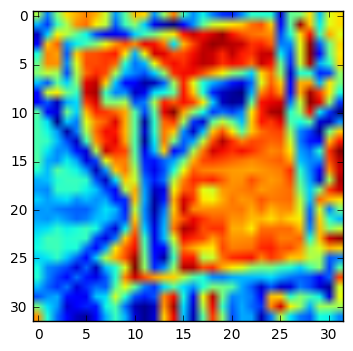

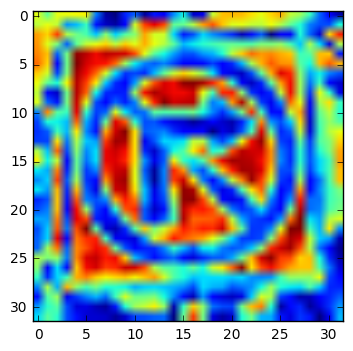

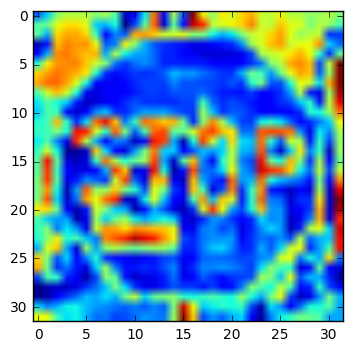

In [49]:
# plot images

for img in test_imgs:
    plt.figure(i)
    plt.imshow(img[:, :, 0])
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The images all look pretty good quality. The "Straight or Right" image has the corner of another sign in it, which might pose a challenge. The biggest issue is that some of them are not in the class set, so the network will not be able to predict those accurately.

End of all speed and passing limits


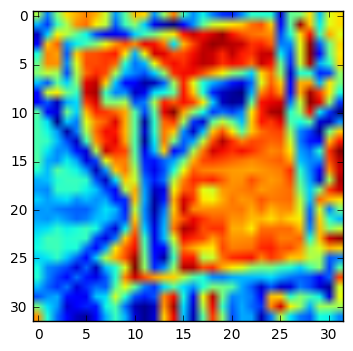

No entry


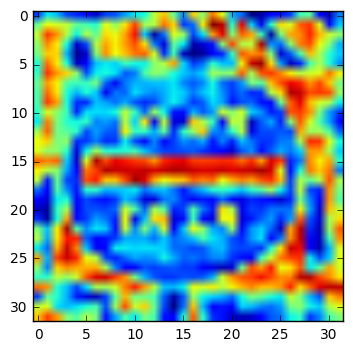

Ahead only


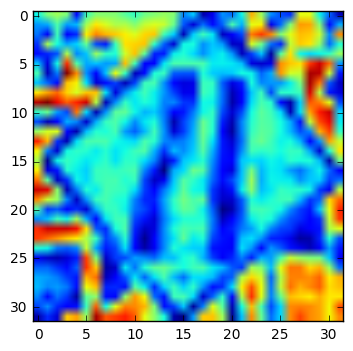

Speed limit (80km/h)


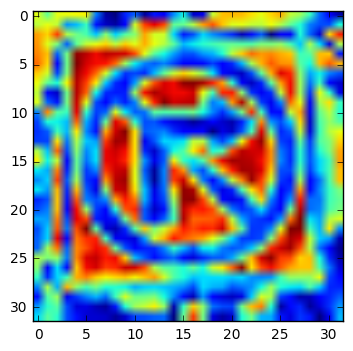

Stop


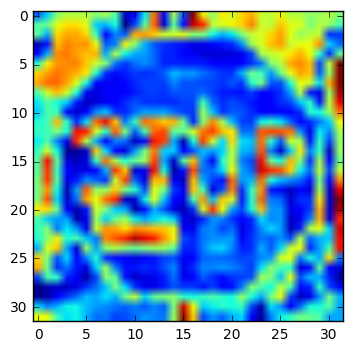

In [52]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

def get_preds(imgs):
    preds = sess.run(model.preds, feed_dict={model.inputs: imgs})
    predicted_labels = np.argmax(preds, axis=1)
    
    return preds, predicted_labels
    
show_imgs_labels(test_imgs, get_preds(test_imgs)[1])

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** It performs decently well on classes in the set. Understandably, it can't perform well on images of classes that it hasn't seen before. In the following plot you can see that the "No Entry" and "Stop" signs are classified with a certainty of nearly 100%, while others such as the first image have probability spread out over multiple classes. A few interesting points: 1. the American "Do Not Enter" image I have looks slightly different from the German counterpart, but is still classified correctly because of its general features. 2. The "Straight or Right" sign is classified incorrectly (although the correct classification is the 3rd most likely.) I believe this is because the sign is a completely different shape (a triangle) than the german counterpart (a circle).

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


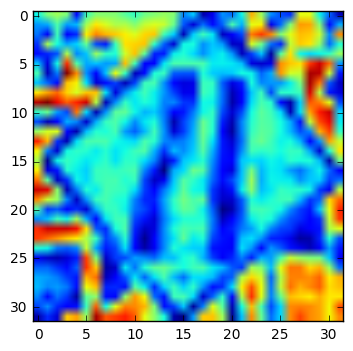

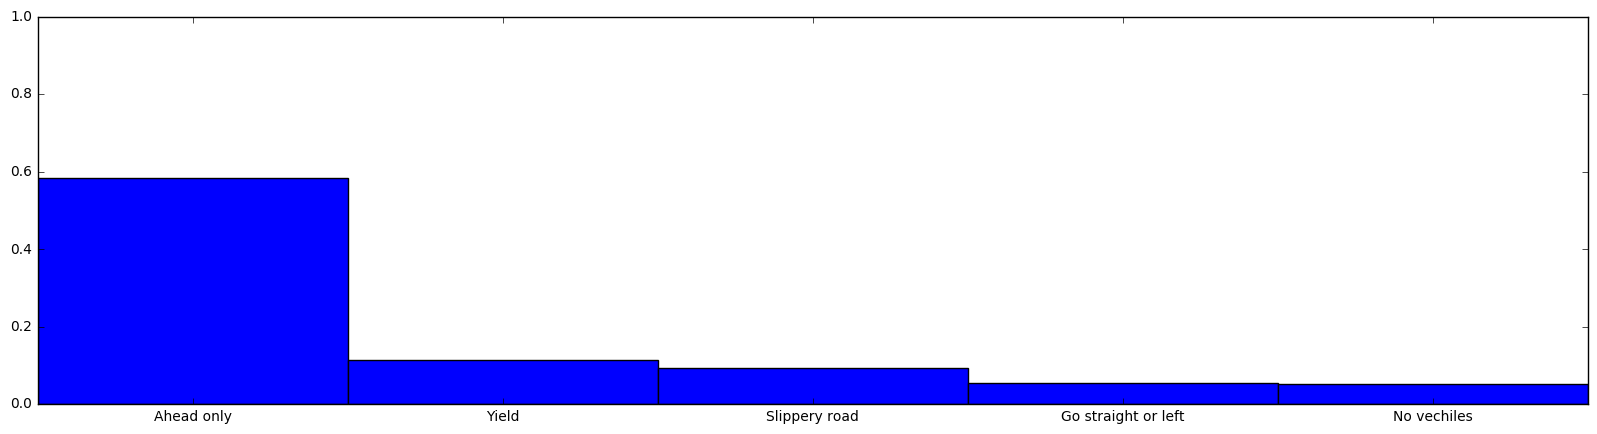

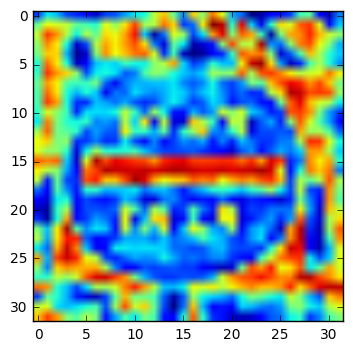

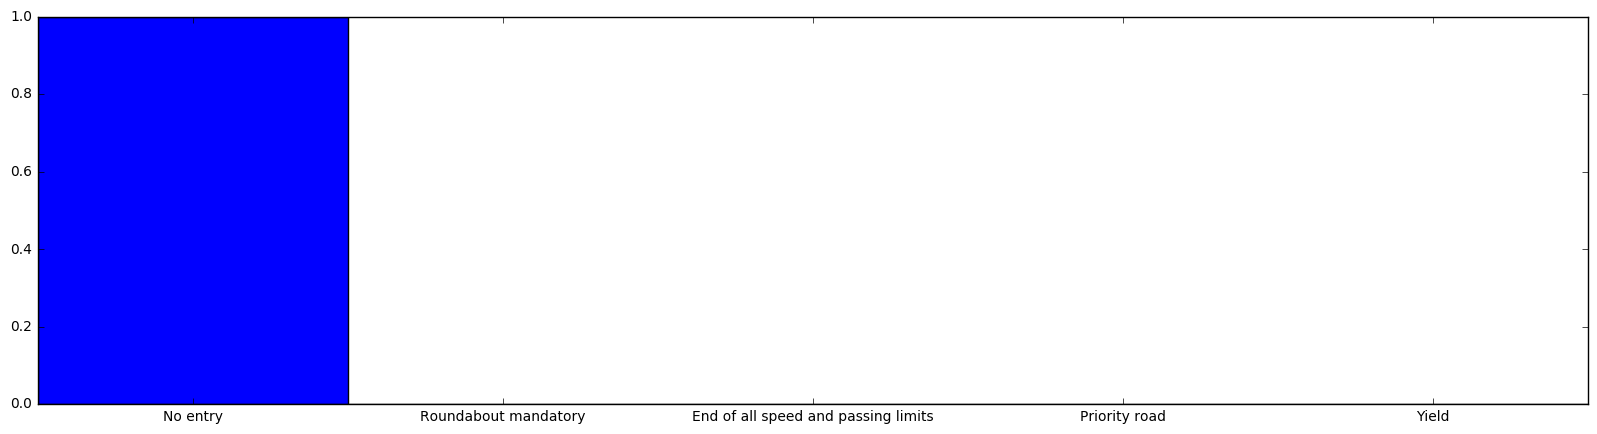

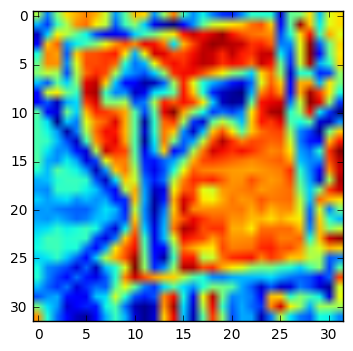

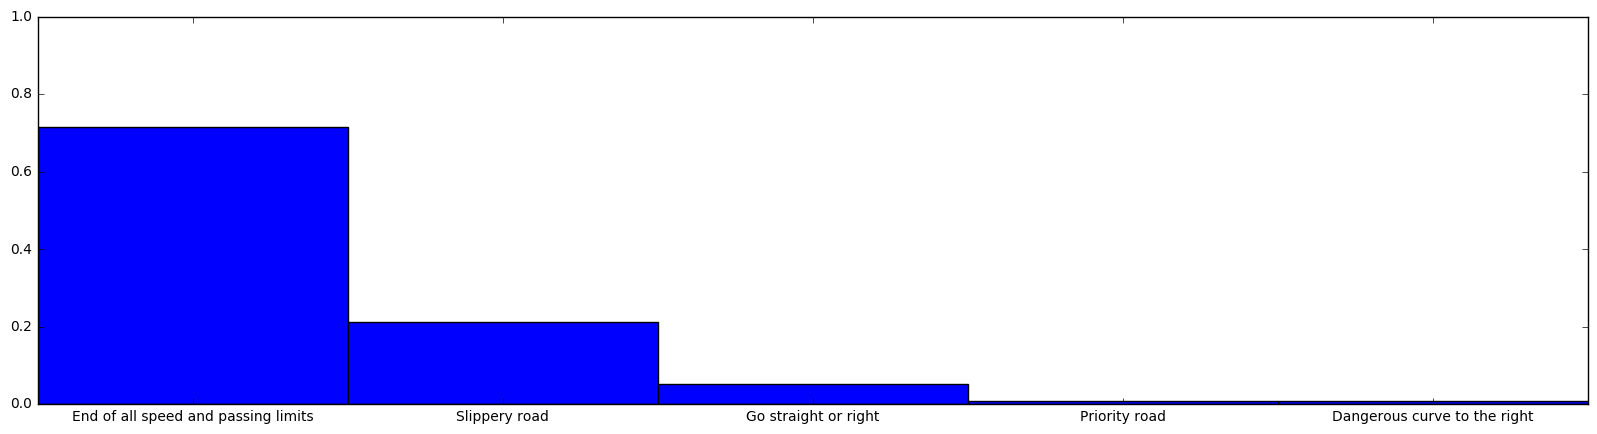

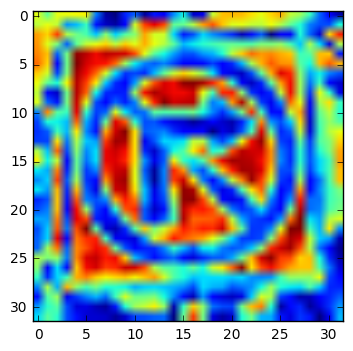

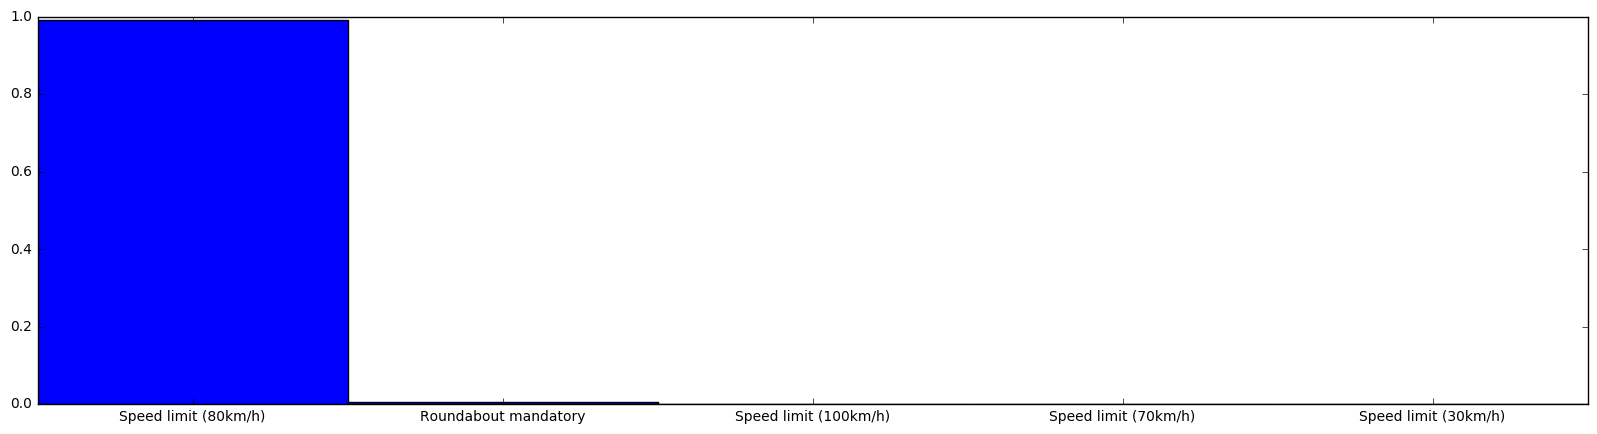

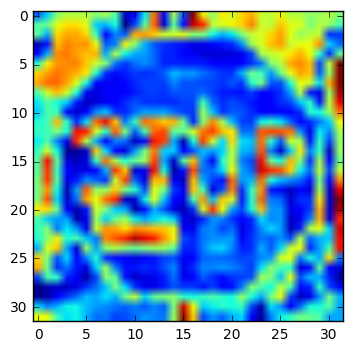

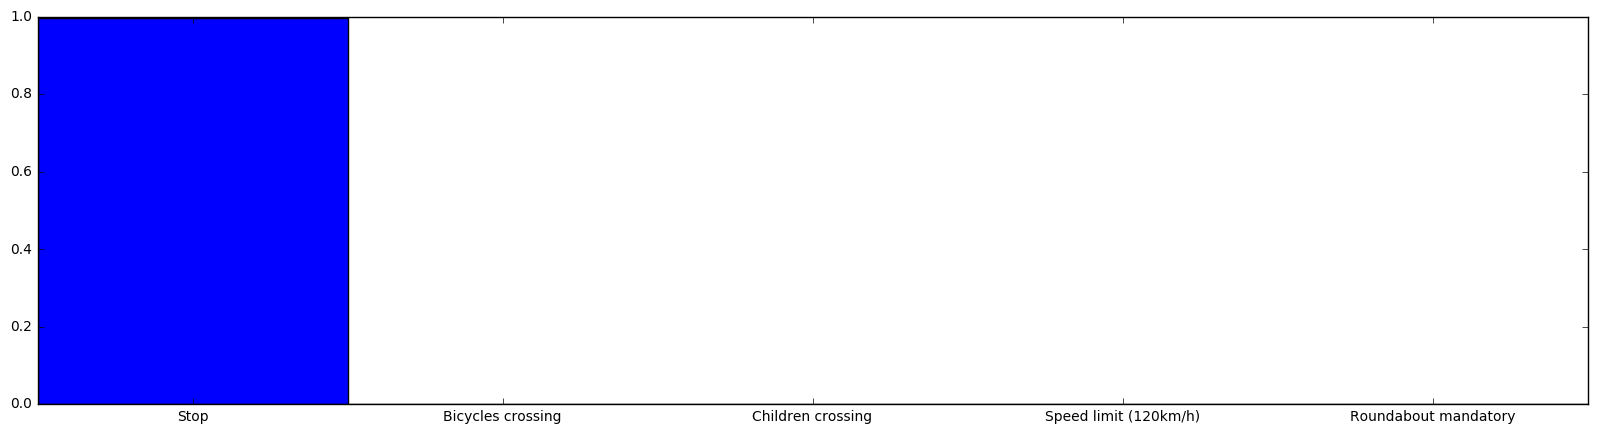

In [69]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

num_top = 5
values, classes = sess.run(tf.nn.top_k(model.preds, k=num_top), feed_dict={model.inputs: test_imgs})

ind = np.arange(num_top)  # the x locations for the groups
width = 1       # the width of the bars
for i, (imvals, imclasses) in enumerate(zip(values, classes)):
    plt.figure(i)
    plt.imshow(test_imgs[i, :, :, 0])
    plt.show()
    
    plt.figure(i + num_top)
    labels = label_names[imclasses]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    rects1 = ax.bar(ind, imvals, width)

    ax.set_xticks(ind + width / 2.)
    ax.set_xticklabels(labels)
    
    plt.axis([0.0,5.0,0.0,1.0])
    
    plt.show()


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** To classify new images, simply run get_preds(imgs), which internally runs the models preds property with the images as input.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.